In [1]:
library(ISLR)
library(MASS)
library(data.table) 
library(ggplot2)
library(dplyr)
library(e1071)
library(rpart)
library(caret)
library(tidyverse)
library(ggplot2)
library(stringr)
library(ISLR)

Warning message:
"package 'ISLR' was built under R version 3.4.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:data.table':

    between, first, last

The following object is masked from 'package:MASS':

    select

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'e1071' was built under R version 3.4.3"Loading required package: lattice
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Conflicts with tidy packages ---------------------------------------------------
between():   dplyr, data.table
filter():    dplyr, stats
first():     dplyr, data.table
lag():       dplyr, stats
last():      dplyr, data.table
lift():      purrr, caret
select():    dplyr, MASS
transpose(): purrr, data.table


In [2]:
colorstats <- read.csv('Stats.csv')
colorstats %>%
  select(Percentage.Black, Percentage.White, Percentage.Blue, Percentage.Red, Percentage.Yellow,
         Percentage.Green, Percentage.Purple, People, Percentage.Cyan, Number.of.Likes) ->stat
stat %>%
    filter(Number.of.Likes <=100) -> stat1

stat1 %>%
    select(Percentage.Black, Percentage.White, Percentage.Blue, Percentage.Red, Percentage.Yellow,
         Percentage.Green, Percentage.Purple, Percentage.Cyan) ->sorted
cbind(sorted, t(apply(sorted, 1, sort, decreasing = TRUE))) -> sorted1
colnames(sorted1) <- c("Percentage.Black", "Percentage.White", "Percentage.Blue", "Percentage.Red", "Percentage.Yellow",
                     "Percentage.Green","Percentage.Purple","Percentage.Cyan", "Color1", "Color2", "Color3",
                     "Color4", "Color5", "Color6", "Color7", "Color8")
sorted1 %>%
 select(Color1, Color2, Color3, Color4, Color5, Color6, Color7, Color8) ->domcolor
dompcolor <- domcolor
domcolor$Likes <- stat1$Number.of.Likes
dompcolor$People <- stat1$People

In [4]:
stat$Likes=log(stat$Number.of.Likes)
train = 1:200
Colors.train = stat[train, ]
Colors.test = stat[-train, ]

Warning message:
"package 'gbm' was built under R version 3.4.3"Loading required package: survival

Attaching package: 'survival'

The following object is masked from 'package:caret':

    cluster

Loading required package: splines
Loading required package: parallel
Loaded gbm 2.1.3


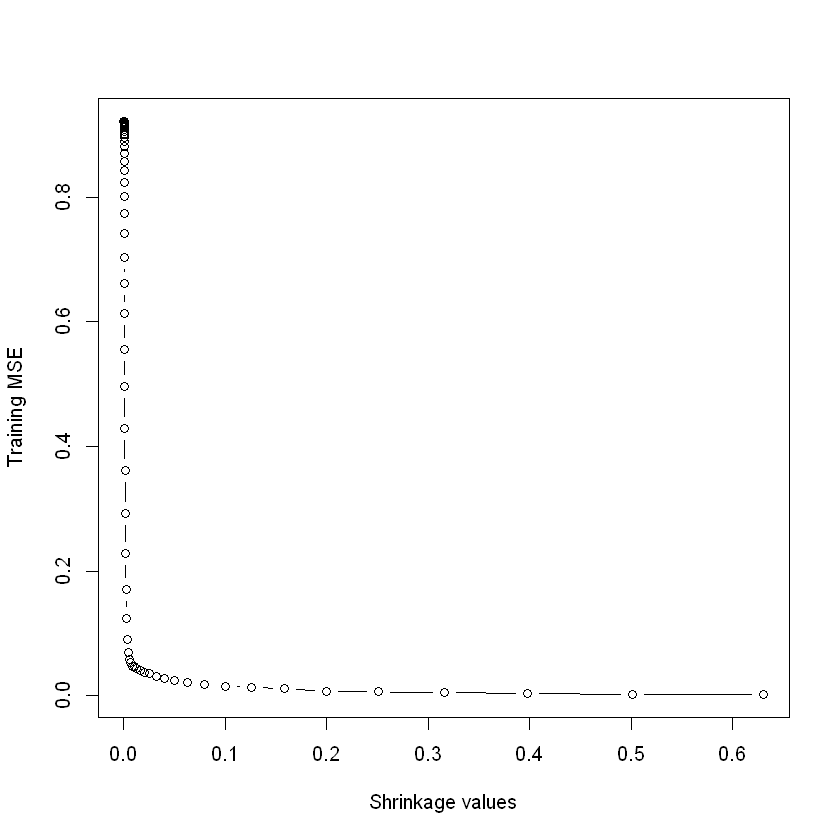

In [5]:
library(gbm)
set.seed(20)
pows <- seq(-10, -0.2, by = 0.1)
lambdas <- 10^pows
trainerror <- rep(0, length(lambdas))
for (i in 1:length(lambdas)) {
    boost.color <- gbm(Likes~., data=Colors.train, distribution = "gaussian",n.trees=1000,shrinkage=lambdas[i])
    pred.train <- predict(boost.color,Colors.train, n.trees = 1000)
    trainerror[i] <- mean((pred.train - Colors.train$Likes)^2)
}

plot(lambdas, trainerror, type = "b", xlab = "Shrinkage values", ylab = "Training MSE")


[1] 0.1076916

[1] 0.06309573

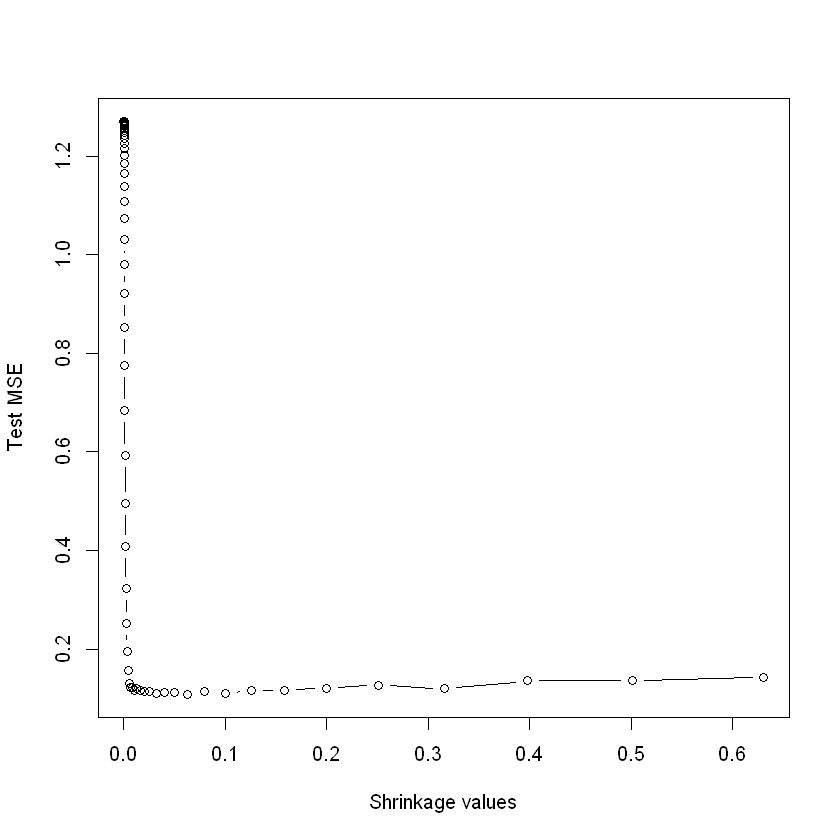

In [6]:
testerr = rep(NA, length(lambdas))
for (i in 1:length(lambdas)) {
    hit = gbm(Likes ~., data=Colors.train, distribution = "gaussian", n.trees = 1000, shrinkage = lambdas[i])
    pred1 = predict(hit, Colors.test, n.trees = 1000)
    testerr[i] = mean((pred1 - Colors.test$Likes)^2)
}
plot(lambdas, testerr, type = "b", xlab = "Shrinkage values", ylab = "Test MSE")


min(testerr)
lambdas[which.min(testerr)]

In [7]:
library(glmnet)
fit1 = lm(Likes ~ ., data = Colors.train)
pred1 = predict(fit1, Colors.test)
mean((pred1 - Colors.test$Likes)^2)

x = model.matrix(Likes ~ ., data = Colors.train)
x.test = model.matrix(Likes ~ ., data = Colors.test)
y = Colors.train$Likes
fit2 = glmnet(x, y, alpha = 0)
pred2 = predict(fit2, s = 0.01, newx = x.test)
mean((pred2 - Colors.test$Likes)^2)

lassofit = glmnet(x, y, alpha = 1) 
lassopred = predict(lassofit, s = 0.01, newx = x.test) 
mean((lassopred - Colors.test$Likes)^2)

Loading required package: Matrix

Attaching package: 'Matrix'

The following object is masked from 'package:tidyr':

    expand

Loading required package: foreach

Attaching package: 'foreach'

The following objects are masked from 'package:purrr':

    accumulate, when

Loaded glmnet 2.0-13



[1] 0.8173911

[1] 0.8163015

[1] 0.8116488

,var,rel.inf
Color4,Color4,62.495400
Color3,Color3,8.117217
Color7,Color7,7.613051
Color6,Color6,6.085062
Color5,Color5,5.329393
Color1,Color1,4.874469
Color2,Color2,3.735630
Color8,Color8,1.749778


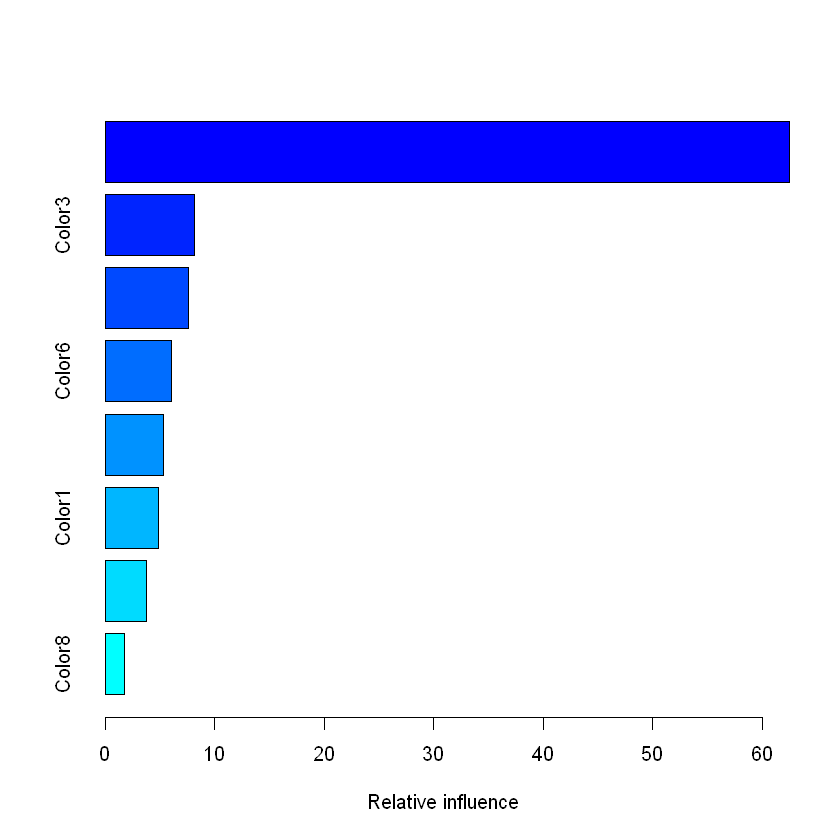

In [8]:
boost = gbm(Likes~.,data=Colors.train,distribution="gaussian", n.trees = 1000,shrinkage = lambdas[which.min(testerr)])
#or is it testerror instead?
summary(boost)


In [9]:
library(randomForest)
set.seed(120)

#2
bag=randomForest(Likes~.,Colors.train,mtry=19,importance=TRUE) 
bagpredict=predict(bag,Colors.test)
bagmse=mean((bagpredict-Colors.test$Likes)^2)
bagmse

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:dplyr':

    combine

The following object is masked from 'package:ggplot2':

    margin

Warning message in randomForest.default(m, y, ...):
"invalid mtry: reset to within valid range"

[1] 0.9469727

In [10]:
cor(domcolor)
#cor(domcolor[,-9])

,Color1,Color2,Color3,Color4,Color5,Color6,Color7,Color8,Likes
Color1,1.00000000,-0.848522171,-0.78308859,-0.70368377,-0.40681532,-0.31049455,-0.24192055,-0.16655144,0.026992013
Color2,-0.84852217,1.000000000,0.41080632,0.32154209,0.15761007,0.13241396,0.09774035,0.09201363,-0.007904246
Color3,-0.78308859,0.410806317,1.00000000,0.71826102,0.26515461,0.13849063,0.10917472,0.07046142,-0.037413936
Color4,-0.70368377,0.321542092,0.71826102,1.00000000,0.35566452,0.21862878,0.14480937,0.07696058,-0.074996830
Color5,-0.40681532,0.157610073,0.26515461,0.35566452,1.00000000,0.72517927,0.55916067,0.27894333,0.027604555
Color6,-0.31049455,0.132413959,0.13849063,0.21862878,0.72517927,1.00000000,0.66959557,0.40028235,0.048467370
Color7,-0.24192055,0.097740348,0.10917472,0.14480937,0.55916067,0.66959557,1.00000000,0.59533180,0.064598371
Color8,-0.16655144,0.092013632,0.07046142,0.07696058,0.27894333,0.40028235,0.59533180,1.00000000,0.015651149
Likes,0.02699201,-0.007904246,-0.03741394,-0.07499683,0.02760455,0.04846737,0.06459837,0.01565115,1.000000000


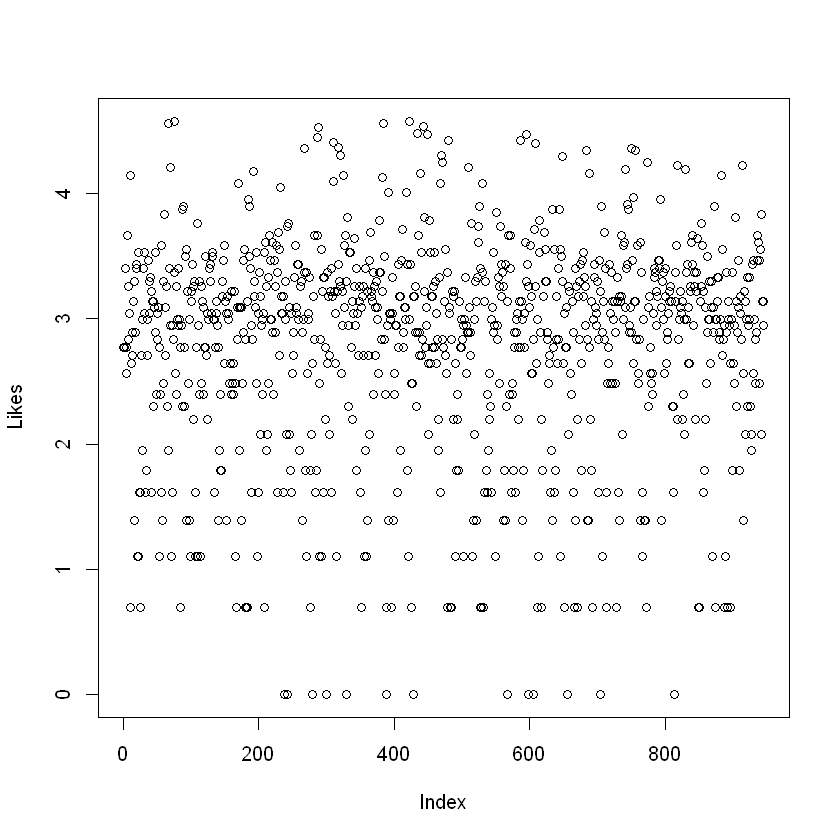

In [11]:
attach(domcolor)
plot(Likes)

In [12]:
glm.fit=glm(Likes~.,data=domcolor, family=binomial)
summary(glm.fit)

ERROR: Error in eval(family$initialize): y values must be 0 <= y <= 1


In [13]:
coef(glm.fit)

ERROR: Error: object of type 'closure' is not subsettable


In [ ]:
summary(glm.fit)$coef

In [ ]:
glm.probs=predict(glm.fit,type="response")
glm.probs[1:10]

In [ ]:
glm.pred=rep("Down",1250)
glm.pred[glm.probs>0.5]="Up"

In [ ]:
table(glm.pred,Direction)
mean(glm.pred==Direction)

In [ ]:
train=sample(1:nrow(dat.mat), nrow(dat.mat)/2)
test=(-train)
Direction.2005=Direction[!train]
glm.fit=glm(Direction~Lag1+Lag2+Lag3+Lag4+Lag5+Volume,
           data=Smarket, family=binomial,subset=train)
glm.probs=predict(glm.fit,Smarket.2005,type="response")

In [ ]:
glm.pred=rep("Down",252)
glm.pred[glm.probs>.5]="Up"
table(glm.pred,Direction.2005)

In [ ]:
mean(glm.pred==Direction.2005)
mean(glm.pred!=Direction.2005)

In [ ]:
predict(glm.fit,newdata=data.frame(Lag1=c(1.2,1.5),Lag2=c(1.1,-0.8)),type="response")

In [43]:
#lda here
library(MASS)
lda.fit=lda(Likes~Color1*Color2, data=domcolor, subset=train)
lda.fit

Call:
lda(Likes ~ Color1 * Color2, data = domcolor, subset = train)

Prior probabilities of groups:
0.693147180559945  1.09861228866811  1.38629436111989   1.6094379124341 
            0.035             0.045             0.035             0.045 
 1.79175946922805  1.94591014905531  2.19722457733622  2.30258509299405 
            0.015             0.020             0.010             0.020 
 2.39789527279837    2.484906649788  2.56494935746154  2.63905732961526 
            0.040             0.040             0.010             0.020 
 2.70805020110221  2.77258872223978  2.83321334405622  2.89037175789616 
            0.025             0.055             0.030             0.020 
 2.94443897916644  2.99573227355399  3.04452243772342  3.09104245335832 
            0.035             0.045             0.045             0.045 
 3.13549421592915  3.17805383034795   3.2188758248682  3.25809653802148 
            0.040             0.015             0.025             0.025 
 3.29583686600433   3.33

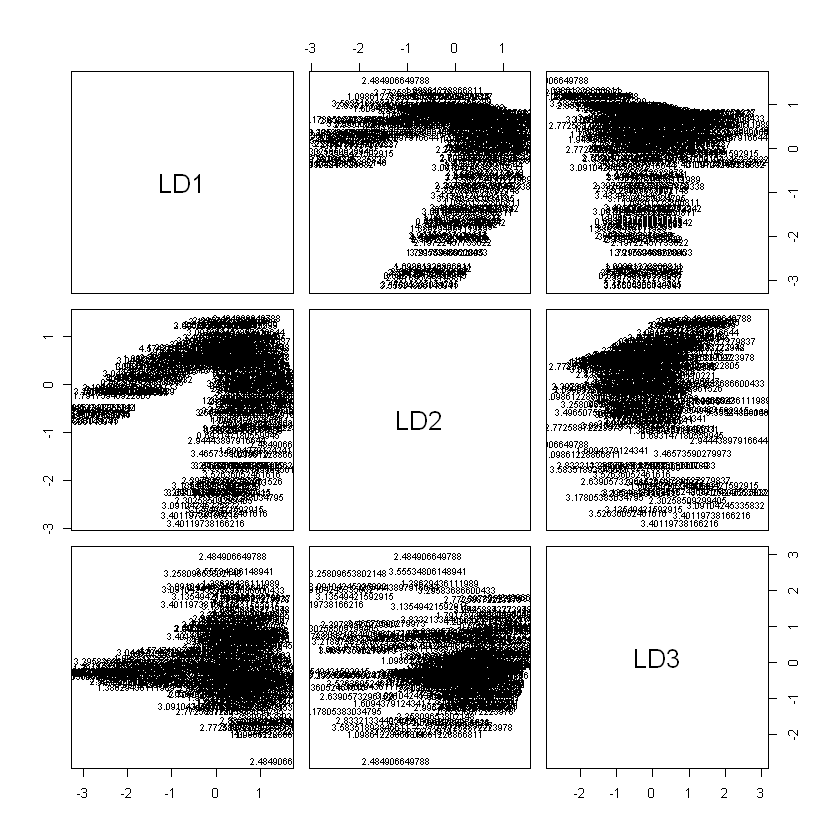

In [44]:
plot(lda.fit)

In [ ]:
lda.pred=predict(lda.fit, Smarket.2005)
names(lda.pred)
lda.class=lda.pred$class
table(lda.class,Direction.2005)
mean(lda.class==Direction.2005)

In [47]:
lda.fit=lda(Likes~Color1*Color2*Color3*Color4, data=domcolor, subset=train)
lda.fit

Call:
lda(Likes ~ Color1 * Color2 * Color3 * Color4, data = domcolor, 
    subset = train)

Prior probabilities of groups:
0.693147180559945  1.09861228866811  1.38629436111989   1.6094379124341 
            0.035             0.045             0.035             0.045 
 1.79175946922805  1.94591014905531  2.19722457733622  2.30258509299405 
            0.015             0.020             0.010             0.020 
 2.39789527279837    2.484906649788  2.56494935746154  2.63905732961526 
            0.040             0.040             0.010             0.020 
 2.70805020110221  2.77258872223978  2.83321334405622  2.89037175789616 
            0.025             0.055             0.030             0.020 
 2.94443897916644  2.99573227355399  3.04452243772342  3.09104245335832 
            0.035             0.045             0.045             0.045 
 3.13549421592915  3.17805383034795   3.2188758248682  3.25809653802148 
            0.040             0.015             0.025             0.025 
 

In [ ]:
plot(lda.fit)

In [ ]:
qda.fit=qda(Likes~., data=domcolor, subset=train)
qda.fit

In [ ]:
qda.class=predict(qda.fit,Smarket.2005)$class
table(qda.class,Direction.2005)
mean(qda.class==Direction.2005)

In [ ]:
library(class)
train.X=cbind(Color1,Color2,Color3,Color4,Color5,Color6,Color7,Color8)[train,]
test.X=cbind(Color1,Color2,Color3,Color4,Color5,Color6,Color7,Color8)[!train,]
train.Direction=Likes[train]

In [ ]:
set.seed(1)
knn.pred=knn(train.X,test.X,train.Direction,k=1)
table(knn.pred,Direction.2005)
#change k accordingly
lda.fit = lda(Likes ~ Color2:Color1, data = domcolor, subset = train)
lda.pred = predict(lda.fit, Weekly.200910)
table(lda.pred$class, Direction.200910)
mean(lda.pred$class == Direction.200910)

qda.fit = qda(Likes ~ Color2 + sqrt(abs(Color2)), data = domcolor, subset = train)
qda.class = predict(qda.fit, Weekly.200910)$class
table(qda.class, Direction.200910)

mean(qda.class == Direction.200910)

In [ ]:
library(glmnet)
fit1 <- lm(Likes ~ ., data = Colors.train)
pred1 <- predict(fit1, Colors.test)
mean((pred1 - Colors.test$Likes)^2)

x <- model.matrix(Likes ~ ., data = Colors.train)
x.test <- model.matrix(Likes ~ ., data = Colors.test)
y <- Colors.train$Likes
fit2 <- glmnet(x, y, alpha = 0)
pred2 <- predict(fit2, s = 0.01, newx = x.test)
mean((pred2 - Colors.test$Likes)^2)

#3

lasso.fit = glmnet(x, y, alpha = 1) #NOT HAS
lasso.pred = predict(lasso.fit, s = 0.01, newx = x.test) #NOT HAS

In [ ]:
boost.colors = gbm(Likes~.,data=Colors.train,distribution="gaussian", n.trees = 1000,shrinkage = lambdas[which.min(test.err)])
summary(boost.hitters)

In [ ]:
set.seed(120)
bag.colors <- randomForest(Likes ~ ., data = Colors.train, mtry = 19, ntree = 500)
yhat.bag <- predict(bag.colors, newdata = Colors.test)
mean((yhat.bag - Colors.test$Likes)^2)

#2
cs.bagging<-randomForest(Likes~.,Colors.train,mtry=19,importance=TRUE) #NO HAS
cs.bagg.predict<-predict(cs.bagging,Colors.test)
cs.bagg.test.mse<-mean((cs.bagg.predict-Colors.test$Likes)^2)
cs.bagg.test.mse
